In [2]:
import os
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from europa_seismo.europa_seismo import rayleigh, minos
from scipy.interpolate import interp1d
from pymc.Matplot import plot
%matplotlib inline

### Read sample dispersion data

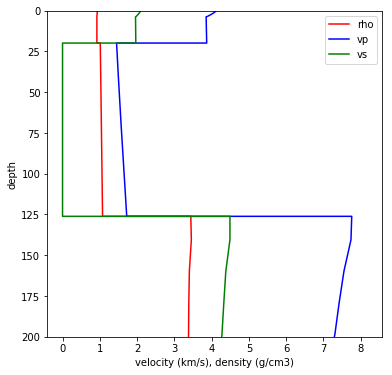

Text(0,0.5,'group velocity (km/s)')

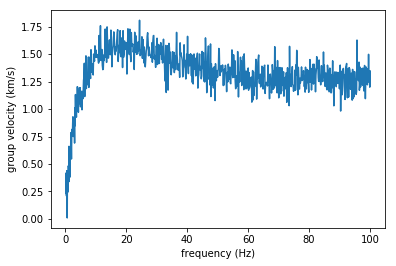

In [5]:
data_obs = np.loadtxt('../data/dispersion_curves/disp_icehot20_test.dat')
f_obs = data_obs[:,0]
vel_obs = data_obs[:,1]

rayleigh.plot_deck_model('../data/models/icehot_20km_simple.txt')

plt.plot(f_obs,vel_obs)
plt.xlabel('frequency (Hz)')
plt.ylabel('group velocity (km/s)')

### Define Monte Carlo model

In [28]:
#get current working directory
cwd = os.getcwd()

#define stochastic variables
h_r = pm.Uniform('h_r',lower=0.0,upper=2.0) #regolith thickness
h_i = pm.Uniform('h_i',lower=h_r,upper=50.0) #ice thickness
vs_r = pm.Uniform('vs_r',lower=0.5,upper=3.5) #regolith shear velocity
vs_i = pm.Uniform('vs_i',lower=1.75,upper=2.25) #ice shear velocity

#define data variance
sigma = 0.1
tau = np.power(sigma,-2)

#define forward model
@pm.deterministic
def mu(h_r=h_r, vs_r=vs_r, h_i=h_i, vs_i=vs_i):
    
    #write current model
    h2o_thickness = 1565000.0 - 1438875
    ocean_thickness = h2o_thickness - (h_i*1000.0)
    layers = rayleigh.make_layers_dict(regolith_thickness = h_r*1000.0,
                                       ice_thickness = h_i*1000.0,
                                       ocean_thickness = ocean_thickness,
                                       vp_regolith=4000.,
                                       vs_regolith=vs_r*1000.0,
                                       vs_ice=vs_i*1000.0)
    
    rayleigh.write_deck_model(layers,output_model='europa.deck',
                              base_model=cwd+'/../data/models/'+'icehot_20km_simple.txt')

    
    #run current model
    modesfile='modes.out'
    eigfile='eig.out'
    eps=1e-10
    wgrav=1.315
    jcom=3
    lmin=0
    lmax=1000
    wmin=0.1
    wmax=100.0 #10 s period
    nmin=0.0                                                                    
    nmax=0.0

    modelfile='europa.deck'
    minos.main(modelfile,modesfile,eigfile,eps,wgrav,jcom,lmin,lmax,wmin,wmax,nmin,nmax)
    f = np.genfromtxt('modes.out')
    freq_mhz = f[:,4]
    group_vel = f[:,6] #group velocity
    
    #interpolate to observed frequencies
    freq_interp = interp1d(freq_mhz,group_vel,bounds_error=None,fill_value='extrapolate')
    vel_modeled = freq_interp(f_obs)
    print len(vel_modeled)
    
    return vel_modeled

#define likelyhood
y = pm.Normal('y', mu=mu, tau=tau, value=vel_obs, observed=True)

#inference
m = pm.Model([h_r,h_i,vs_r,vs_i,tau,y])
mc = pm.MCMC(m)
mc.sample(iter=1000,burn=200)

761


/home/romaguir/anaconda2/lib/python2.7/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


761
 [                  0%                  ] 2 of 1000 complete in 1.3 sec761
 [                  0%                  ] 3 of 1000 complete in 2.8 sec761
761
761
 [                  0%                  ] 4 of 1000 complete in 5.7 sec761
761
761
 [                  0%                  ] 6 of 1000 complete in 8.1 sec761
761
761
 [                  0%                  ] 7 of 1000 complete in 10.5 sec761
 [                  0%                  ] 8 of 1000 complete in 11.3 sec761
761
 [                  0%                  ] 9 of 1000 complete in 12.9 sec761
761
 [                  1%                  ] 10 of 1000 complete in 14.4 sec761
 [                  1%                  ] 11 of 1000 complete in 15.3 sec761
761
761
 [                  1%                  ] 12 of 1000 complete in 18.0 sec761
761
 [                  1%                  ] 13 of 1000 complete in 19.6 sec761
761
 [                  1%                  ] 14 of 1000 complete in 21.2 sec761
 [                  1%             

 [---------        23%                  ] 237 of 1000 complete in 282.9 sec761
 [---------        23%                  ] 238 of 1000 complete in 284.3 sec761
761
761
 [---------        24%                  ] 240 of 1000 complete in 286.4 sec761
761
 [---------        24%                  ] 241 of 1000 complete in 288.0 sec761
761
 [---------        24%                  ] 242 of 1000 complete in 289.8 sec761
761
761
761
 [---------        24%                  ] 243 of 1000 complete in 292.9 sec761
 [---------        24%                  ] 244 of 1000 complete in 293.4 sec761
761
761
 [---------        24%                  ] 245 of 1000 complete in 296.3 sec761
761
761
 [---------        24%                  ] 246 of 1000 complete in 299.1 sec761
761
 [---------        24%                  ] 247 of 1000 complete in 300.9 sec761
 [---------        24%                  ] 248 of 1000 complete in 301.6 sec761
 [---------        24%                  ] 249 of 1000 complete in 302.4 sec761
761


 [-----------------46%                  ] 466 of 1000 complete in 550.9 sec761
761
761
 [-----------------46%                  ] 467 of 1000 complete in 553.2 sec761
 [-----------------46%                  ] 468 of 1000 complete in 554.6 sec761
 [-----------------46%                  ] 469 of 1000 complete in 555.4 sec761
761
 [-----------------47%                  ] 470 of 1000 complete in 556.9 sec761
 [-----------------47%                  ] 472 of 1000 complete in 557.4 sec761
761
 [-----------------47%                  ] 473 of 1000 complete in 558.9 sec761
 [-----------------47%                  ] 474 of 1000 complete in 560.4 sec761
761
 [-----------------47%                  ] 476 of 1000 complete in 561.7 sec761
761
 [-----------------47%                  ] 477 of 1000 complete in 563.8 sec761
761
761
 [-----------------47%                  ] 478 of 1000 complete in 566.4 sec761
761
761
 [-----------------48%                  ] 480 of 1000 complete in 568.4 sec761
761
 [------

 [-----------------70%------            ] 701 of 1000 complete in 840.7 sec761
 [-----------------70%------            ] 702 of 1000 complete in 841.5 sec761
 [-----------------70%------            ] 703 of 1000 complete in 842.0 sec761
761
761
 [-----------------70%------            ] 704 of 1000 complete in 844.9 sec761
761
761
 [-----------------70%------            ] 705 of 1000 complete in 847.0 sec761
761
761
 [-----------------70%------            ] 706 of 1000 complete in 850.0 sec761
 [-----------------70%------            ] 707 of 1000 complete in 850.7 sec761
 [-----------------70%------            ] 708 of 1000 complete in 851.4 sec761
 [-----------------71%------            ] 710 of 1000 complete in 852.2 sec761
 [-----------------71%-------           ] 711 of 1000 complete in 853.0 sec761
761
 [-----------------71%-------           ] 712 of 1000 complete in 854.4 sec761
 [-----------------71%-------           ] 713 of 1000 complete in 855.2 sec761
761
761
 [--------------

761
 [-----------------83%-----------       ] 834 of 1000 complete in 978.8 sec761
 [-----------------83%-----------       ] 835 of 1000 complete in 979.4 sec761
761
 [-----------------83%-----------       ] 836 of 1000 complete in 980.8 sec761
761
 [-----------------83%-----------       ] 837 of 1000 complete in 982.1 sec761
 [-----------------83%-----------       ] 838 of 1000 complete in 982.9 sec761
 [-----------------83%-----------       ] 839 of 1000 complete in 983.6 sec761
761
 [-----------------84%-----------       ] 840 of 1000 complete in 985.1 sec761
761
 [-----------------84%-----------       ] 841 of 1000 complete in 987.0 sec761
761
 [-----------------84%-----------       ] 842 of 1000 complete in 988.7 sec761
761
 [-----------------84%------------      ] 843 of 1000 complete in 990.5 sec761
 [-----------------84%------------      ] 844 of 1000 complete in 991.1 sec761
761
 [-----------------84%------------      ] 845 of 1000 complete in 992.4 sec761
 [-----------------8

Plotting h_r
Plotting h_i
Plotting vs_r
Plotting vs_i


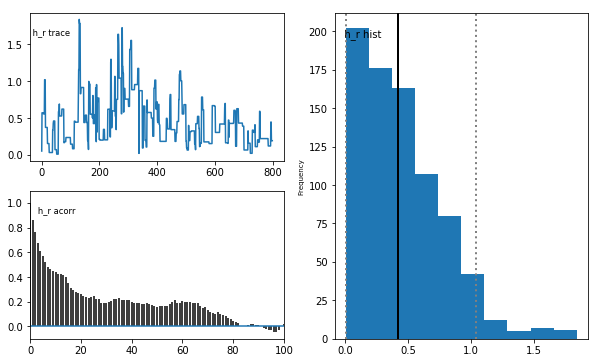

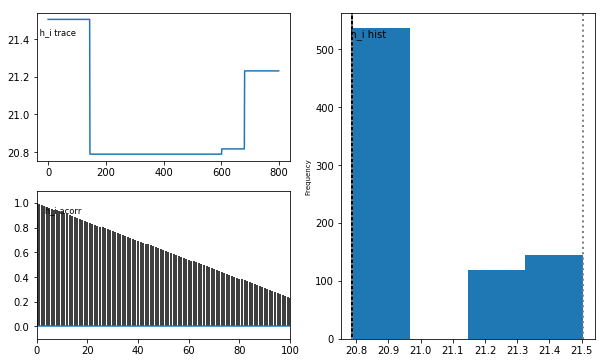

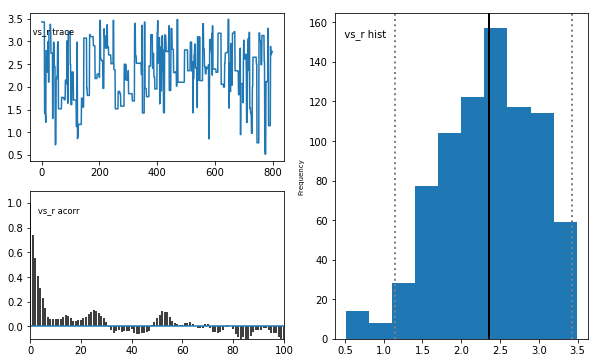

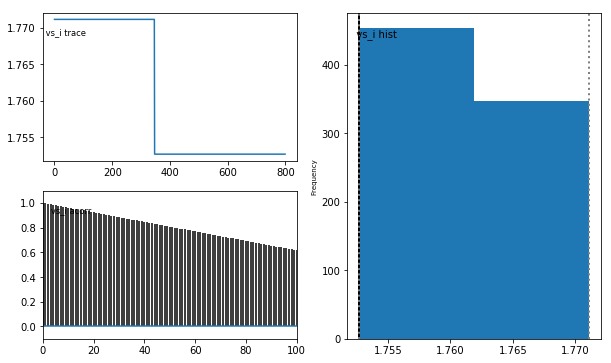

In [30]:
plot(mc)

In [36]:
h2o_thickness = 1565000.0 - 1438875
h_r_mean =  np.mean(h_r.trace())
h_i_mean =  np.mean(h_i.trace())
vs_r_mean =  np.mean(vs_r.trace())
vs_i_mean =  np.mean(vs_i.trace())
ocean_thickness = h2o_thickness - (h_i_mean*1000.0)

### Compare mean model with target model

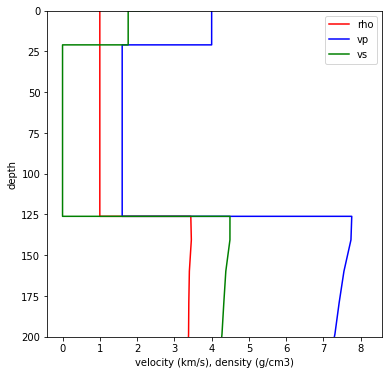

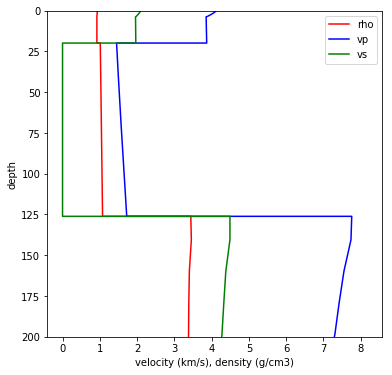

In [38]:
layers = rayleigh.make_layers_dict(regolith_thickness = h_r_mean*1000.0,
                                    ice_thickness = h_i_mean*1000.0,
                                    ocean_thickness = ocean_thickness,
                                    vp_regolith=4000.,
                                    vs_regolith=vs_r_mean*1000.0,
                                    vs_ice=vs_i_mean*1000.0)

rayleigh.write_deck_model(layers,output_model='europa_mean.deck',
                          base_model=cwd+'/../data/models/'+'icehot_20km_simple.txt')
rayleigh.plot_deck_model('europa_mean.deck')
rayleigh.plot_deck_model('../data/models/icehot_20km_simple.txt')

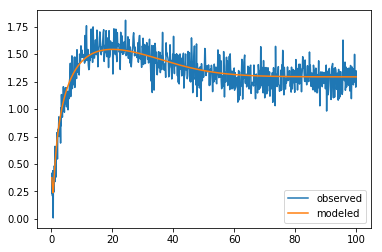

In [41]:
#run current model
modesfile='modes.out'
eigfile='eig.out'
eps=1e-10
wgrav=1.315
jcom=3
lmin=0
lmax=1000
wmin=0.1
wmax=100.0 #10 s period
nmin=0.0                                                                    
nmax=0.0

modelfile='europa_mean.deck'
minos.main(modelfile,modesfile,eigfile,eps,wgrav,jcom,lmin,lmax,wmin,wmax,nmin,nmax)
f = np.genfromtxt('modes.out')
freq_mhz = f[:,4]
group_vel = f[:,6] #group velocity
    
#interpolate to observed frequencies
freq_interp = interp1d(freq_mhz,group_vel,bounds_error=None,fill_value='extrapolate')
vel_modeled = freq_interp(f_obs)

plt.plot(f_obs,vel_obs,label='observed')
plt.plot(f_obs,vel_modeled,label='modeled')
plt.legend()
plt.show()